# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [5]:
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [6]:
j = 1
print(X_train.columns[j])

Mileage


In [7]:
import pandas as pd
import numpy as np

# Split the variable in num_ctp points
splits = np.percentile(X_train.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())

In [8]:
splits

array([6.000000e+00, 1.603480e+04, 2.324080e+04, 2.987540e+04,
       3.565100e+04, 4.160950e+04, 4.849280e+04, 6.199830e+04,
       8.097420e+04, 1.061537e+05])

In [9]:
k = 5

In [10]:
filter_l = X_train.iloc[:, j] < splits[k]

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

In [11]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [12]:
gini_l = gini(y_l)
gini_l

0.20474618023837854

In [13]:
gini_r = gini(y_r)
gini_r

0.3959988713681828

In [14]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [15]:
gini_impurity(X_train.iloc[:, j], y_train, splits[k])

0.18743041714283493

In [16]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [17]:
j, split, gain = best_split(X_train, y_train, 5)
j, split, gain

(1, 56598.66666666667, 0.23507164147905313)

In [18]:
filter_l = X_train.iloc[:, j] < split

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

In [19]:

y.shape[0], y_l.shape[0], y_r.shape[0]

(13150, 5873, 2937)

In [20]:
y_train.mean(), y_l.mean(), y_r.mean()

(0.5780930760499432, 0.8205346500936489, 0.09329247531494722)

In [21]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [22]:
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=4, num_pct=10)

In [23]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [24]:
y_pred=tree_predict(X_test, tree)

In [25]:
from sklearn import metrics
metrics.accuracy_score(y_pred, y_test)


0.864516129032258

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [26]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [30]:
#from sklearn.tree import DecisionTreeRegressor

# grow each tree deep
#treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame for storing predicted price from each tree
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# grow one tree for each bootstrap sample and make predictions on testing data
for i, sample in enumerate(samples):
    X_train_ = X_train.iloc[samples[i]]
    y_train_ = y_train.iloc[samples[i]]
    tree=tree_grow(X_train_, y_train_, level=0, min_gain=0.001, max_depth=4, num_pct=10)
    y_pred[i]=tree_predict(X_test, tree)


In [31]:
y_pred.head()

,0,1,2,3,4,5,6,7,8,9
332784,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
146436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
for i in range(n_B):
    print(i, metrics.accuracy_score(y_pred[i], y_test))

0 0.8624423963133641
1 0.8707373271889401
2 0.8700460829493087
3 0.8672811059907835
4 0.8675115207373272
5 0.8649769585253456
6 0.8612903225806452
7 0.8684331797235023
8 0.866589861751152
9 0.8691244239631336


In [33]:
y_pred_final = (y_pred.sum(axis=1) >= (n_B / 2)).astype(np.int)

In [34]:
print("F1:",metrics.f1_score(y_pred_final, y_test))
print("Accuracy:",metrics.accuracy_score(y_pred_final, y_test))

F1: 0.8944685671134606
Accuracy: 0.8711981566820276


Mejoró al utilizar el Bagging

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [35]:
def tree_grow_max(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10,max_features=9):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    s_index = np.random.choice(a=X.shape[1], size=max_features, replace=False)
    X_sample=X.iloc[:, s_index]
    j, split, gain = best_split(X_sample, y, num_pct)
    j=s_index[j]
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow_max(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    tree['sr'] = tree_grow_max(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    
    return tree

In [36]:
tree=tree_grow_max(X_train, y_train, level=0, min_gain=0.001, max_depth=4, num_pct=10, max_features=3)
y_pred=tree_predict(X_test, tree)

In [37]:
metrics.accuracy_score(y_pred, y_test)

0.8354838709677419

In [38]:
features = range(1, X_train.shape[1]+1)
# list to store the average Accuracy for each value of max_features
accuracy = []
plot_accu = []

for feature in features:
    tree=tree_grow_max(X_train, y_train, level=0, min_gain=0.001, max_depth=4, num_pct=10, max_features=feature)
    y_pred=tree_predict(X_test, tree)
    accuracy.append([feature, metrics.accuracy_score(y_pred, y_test), metrics.f1_score(y_pred, y_test)])
    plot_accu.append(metrics.accuracy_score(y_pred, y_test))
    
accuracy=pd.DataFrame(accuracy, columns=['feature', 'Accuracy','F1Sco']) 
accuracy

,feature,Accuracy,F1Sco
0,1,0.841475,0.870919
1,2,0.850230,0.882925
2,3,0.857604,0.878155
3,4,0.856221,0.883321
4,5,0.861521,0.883505
5,6,0.865668,0.888207
6,7,0.865668,0.888207
7,8,0.864516,0.888213
8,9,0.864516,0.888213


Es evidente que el utilizar diferente número de variables máximas hace que cambie el accuracy del modelo

Text(0,0.5,'Accuracy')

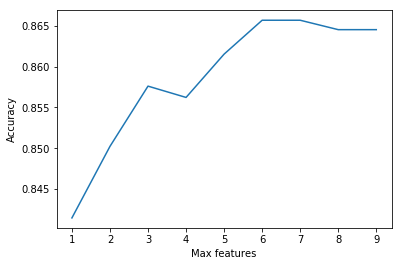

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(features, plot_accu)
plt.xlabel('Max features')
plt.ylabel('Accuracy')

No necesariamente el útilizar la totalidad de features en el parámetro max_features da el mejor accuracy, utilizar muy pocas como una o dos tampoco es la mejor opción

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [42]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

#seeds = np.random.randint(1, 10000, size=n_B)
# Predict Arboles
y_pred_df_trees = pd.DataFrame(index=X_test.index, columns=list(range(n_B)))
trees = {}
for i in range(10):
    trees[i] = tree_grow_max(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=4, num_pct=10,max_features=int(np.log(X_train.shape[1]+1)))
    y_pred_df_trees.iloc[:, i] = tree_predict(X_test, trees[i])
    
y_pred = (y_pred_df_trees.sum(axis=1) >= (n_B / 2)).astype(np.int)



In [43]:
print("F1:",metrics.f1_score(y_pred, y_test))
print("Accuracy:",metrics.accuracy_score(y_pred, y_test))

F1: 0.8561187916026627
Accuracy: 0.8057603686635945


# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [45]:
# use 10-fold cross-validation with each value of max_depth
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)


In [46]:
print("F1:",metrics.f1_score(y_pred, y_test))
print("Accuracy:",metrics.accuracy_score(y_pred, y_test))

F1: 0.8615751789976134
Accuracy: 0.83963133640553


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

Primero el número de estimadores:

In [48]:
from sklearn.model_selection import cross_val_score
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

In [57]:
estima=pd.DataFrame(accuracy_scores, columns=['Accuracy'], index=range(10, 310, 10)) 
estima

,Accuracy
10,0.838174
20,0.839618
30,0.838630
40,0.837717
50,0.836425
60,0.836805
70,0.836729
80,0.836272
90,0.836424
100,0.836500


Text(0,0.5,'Accuracy')

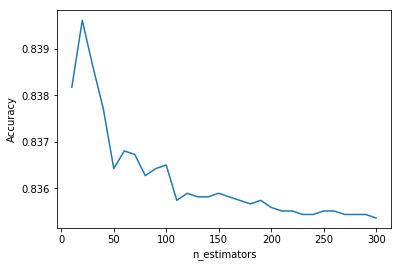

In [49]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')


Parece ser que el mejor número de estimadores es 20

Ahora el parámetro max_features

In [59]:
# list of values to try for max_features
feature_range = range(1, X_train.shape[1]+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=20, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

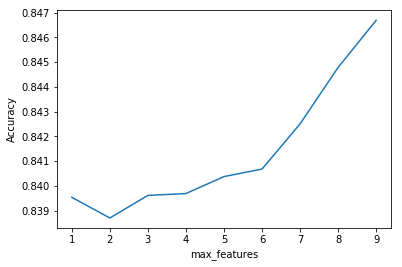

In [60]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

Al parecer el mejor accuracy en este caso si se da cuando el número maximo de variables es 9

Ahora el parámetro max_depth

In [65]:
# list of values to try for max_features
depths = range(1, 30)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for depth in depths:
    clf = RandomForestClassifier(n_estimators=20,max_depth=depth ,random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

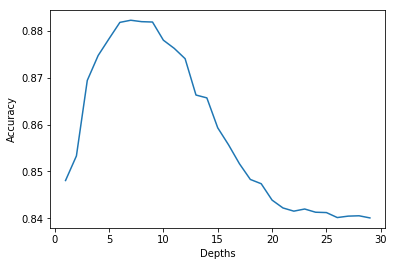

In [66]:
plt.plot(depths, accuracy_scores)
plt.xlabel('Depths')
plt.ylabel('Accuracy')

In [68]:
depth_df=pd.DataFrame(accuracy_scores, columns=['Accuracy'], index=range(1, 30)) 
#estima
result = depth_df.sort_values(['Accuracy'], ascending=[0])
result

,Accuracy
7,0.882282
8,0.881978
9,0.881901
6,0.881826
5,0.878328
10,0.878023
11,0.876274
4,0.874753
12,0.874069
3,0.869430


Finalmente generar uno con los mejores parámetros obtenidos

In [69]:
clf = RandomForestClassifier(n_estimators=20, max_features=9,max_depth=8, random_state=1, n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [71]:
print("F1:",metrics.f1_score(y_pred, y_test))
print("Accuracy:",metrics.accuracy_score(y_pred, y_test))

F1: 0.8969766994030426
Accuracy: 0.8767281105990783
